In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import matplotlib_fontja
import separator
import noisereduce as nr
import soundfile as sf
import scipy.signal as signal


c:\Users\satok\github\20250627_0705_MusicPitchFinder\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
url = input("Enter the YouTube video URL: ")
file = separator.download_and_separate_audio(url)
NoRevarb_file = separator.revarb_remove(f"./separated_audio/{file}")
Noharmony_file = separator.harmony_remove(f"./separated_audio/{NoRevarb_file}")
output_file = separator.noize_remove(f"./separated_audio/{Noharmony_file}")


[youtube] Extracting URL: https://youtu.be/xxFkW3PCT5M?si=rLpo5fnoiGGR8j22
[youtube] xxFkW3PCT5M: Downloading webpage
[youtube] xxFkW3PCT5M: Downloading tv client config
[youtube] xxFkW3PCT5M: Downloading tv player API JSON
[youtube] xxFkW3PCT5M: Downloading ios player API JSON
[youtube] xxFkW3PCT5M: Downloading m3u8 information
[info] xxFkW3PCT5M: Downloading 1 format(s): 251
[download] Destination: downloaded_audio\download.webm
[download] 100% of    4.83MiB in 00:00:00 at 9.78MiB/s     
[ExtractAudio] Destination: downloaded_audio\download.wav
Deleting original file downloaded_audio\download.webm (pass -k to keep)
[Metadata] Adding metadata to "downloaded_audio\download.wav"
[youtube] Extracting URL: https://youtu.be/xxFkW3PCT5M?si=rLpo5fnoiGGR8j22
[youtube] xxFkW3PCT5M: Downloading webpage
[youtube] xxFkW3PCT5M: Downloading tv client config
[youtube] xxFkW3PCT5M: Downloading tv player API JSON
[youtube] xxFkW3PCT5M: Downloading ios player API JSON
[youtube] xxFkW3PCT5M: Downloading

2025-06-29 17:27:01,539 - INFO - separator - Separator version 0.34.1 instantiating with output_dir: ./separated_audio, output_format: WAV
2025-06-29 17:27:01,539 - INFO - separator - Using model directory from model_file_dir parameter: /tmp/audio-separator-models/
2025-06-29 17:27:01,540 - INFO - separator - Operating System: Windows 10.0.22631
2025-06-29 17:27:01,540 - INFO - separator - System: Windows Node: Yuzuki_PC Release: 11 Machine: AMD64 Proc: Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
2025-06-29 17:27:01,540 - INFO - separator - Python Version: 3.13.5
2025-06-29 17:27:01,541 - INFO - separator - PyTorch Version: 2.7.1+cu128
2025-06-29 17:27:01,560 - INFO - separator - FFmpeg installed: ffmpeg version 7.1.1-full_build-www.gyan.dev Copyright (c) 2000-2025 the FFmpeg developers
2025-06-29 17:27:01,562 - INFO - separator - ONNX Runtime GPU package installed with version: 1.22.0
2025-06-29 17:27:01,572 - INFO - separator - CUDA is available in Torch, setting Torch device

Downloaded audio for: 【初音ミク(40㍍)】 からくりピエロ Karakuri Pierrot【オリジナル】
【初音ミク(40㍍)】_からくりピエロ_Karakuri_Pierrot【オリジナル】


2025-06-29 17:27:03,998 - INFO - mdxc_separator - MDXC Separator initialisation complete
2025-06-29 17:27:03,999 - INFO - separator - Load model duration: 00:00:02
2025-06-29 17:27:03,999 - INFO - separator - Processing file: ./downloaded_audio/download.wav
2025-06-29 17:27:04,000 - INFO - separator - Starting separation process for audio_file_path: ./downloaded_audio/download.wav
100%|██████████| 37/37 [00:22<00:00,  1.66it/s]
2025-06-29 17:27:28,064 - INFO - mdxc_separator - Saving vocals stem to Vocals.wav...
2025-06-29 17:27:28,194 - INFO - common_separator - Audio duration is 0.08 hours (294.77 seconds).
2025-06-29 17:27:28,195 - INFO - common_separator - Using pydub for writing.
2025-06-29 17:27:28,735 - INFO - common_separator - Clearing input audio file paths, sources and stems...
2025-06-29 17:27:28,781 - INFO - separator - Separation duration: 00:00:24
2025-06-29 17:27:28,786 - INFO - separator - Separator version 0.34.1 instantiating with output_dir: ./separated_audio, outpu

In [11]:
file = './separated_audio/noize_removed.wav'
audio, sr = librosa.load(file)
normalized_audio = librosa.util.normalize(audio)
output_path = './separated_audio/final_output.wav'
sf.write(output_path, normalized_audio, sr)

audio, sr = librosa.load(output_path)

In [12]:
top_db = 30

fmin=librosa.note_to_hz('C1')
fmax=librosa.note_to_hz('C7')
frame_length = 2048
hop_length = frame_length // 4

intervals = librosa.effects.split(audio, top_db=top_db, frame_length=frame_length, hop_length=hop_length)

print(f"元の音声長: {librosa.get_duration(y=audio, sr=sr):.2f} 秒")
print(f"検出された有効な音声区間の数: {len(intervals)}")
for i, (start, end) in enumerate(intervals):
    print(f"  区間 {i}: {start/sr:.2f} 秒から {end/sr:.2f} 秒まで")

# --- 3. 各区間でピッチを推定し、結果を結合 ---
all_f0 = []
all_voiced_flags = []
all_voiced_probs = []

print("\n各区間でPYINを実行中...")

for start_i, end_i in intervals:
    # 区間ごとの音声データを切り出す
    y_interval = audio[start_i:end_i]
    
    # 区間ごとにPYINを実行
    f0, voiced_flag, voiced_prob = librosa.pyin(
        y_interval,
        fmin=fmin,
        fmax=fmax,
        sr=sr,
        frame_length=frame_length,
        hop_length=hop_length
    )
    
    # 結果をリストに追加
    all_f0.append(f0)
    all_voiced_flags.append(voiced_flag)
    all_voiced_probs.append(voiced_prob)
    print(f"  区間 {start_i/sr:.2f} 秒から {end_i/sr:.2f} 秒までのピッチ推定完了。")
    print("進捗: {:.2f}%".format((start_i / len(audio)) * 100))

# 全区間の結果を一つのNumpy配列に結合
if all_f0:
    f0_combined = np.concatenate(all_f0)
    voiced_flag_combined = np.concatenate(all_voiced_flags)
    voiced_prob_combined = np.concatenate(all_voiced_probs)
else:
    # 有効な区間が一つもなかった場合
    f0_combined, voiced_flag_combined, voiced_prob_combined = [], [], []

print("PYINの実行完了。")

元の音声長: 294.76 秒
検出された有効な音声区間の数: 123
  区間 0: 49.11 秒から 51.20 秒まで
  区間 1: 51.46 秒から 52.34 秒まで
  区間 2: 52.36 秒から 53.64 秒まで
  区間 3: 53.80 秒から 54.68 秒まで
  区間 4: 54.71 秒から 56.40 秒まで
  区間 5: 56.47 秒から 58.12 秒まで
  区間 6: 58.51 秒から 59.33 秒まで
  区間 7: 59.37 秒から 59.63 秒まで
  区間 8: 59.70 秒から 60.67 秒まで
  区間 9: 60.86 秒から 63.02 秒まで
  区間 10: 63.23 秒から 63.79 秒まで
  区間 11: 63.81 秒から 65.92 秒まで
  区間 12: 65.99 秒から 66.85 秒まで
  区間 13: 67.01 秒から 69.15 秒まで
  区間 14: 69.40 秒から 71.56 秒まで
  区間 15: 71.75 秒から 72.86 秒まで
  区間 16: 72.93 秒から 76.30 秒まで
  区間 17: 76.42 秒から 78.62 秒まで
  区間 18: 78.76 秒から 80.97 秒まで
  区間 19: 81.18 秒から 82.31 秒まで
  区間 20: 82.36 秒から 83.45 秒まで
  区間 21: 83.52 秒から 84.92 秒まで
  区間 22: 84.96 秒から 85.61 秒まで
  区間 23: 86.26 秒から 86.75 秒まで
  区間 24: 86.84 秒から 87.24 秒まで
  区間 25: 87.35 秒から 87.91 秒まで
  区間 26: 88.03 秒から 88.42 秒まで
  区間 27: 88.51 秒から 89.09 秒まで
  区間 28: 89.21 秒から 89.65 秒まで
  区間 29: 89.68 秒から 90.91 秒まで
  区間 30: 91.00 秒から 91.44 秒まで
  区間 31: 91.58 秒から 92.00 秒まで
  区間 32: 92.04 秒から 92.62 秒まで
  区間 33: 92.76 秒か

In [17]:
import math

def my_round_int(number):
    return int((number * 2 + 1) // 2)

def hz_to_midi(hz):
    midi = 12 * (math.log2(hz / 440)) + 69
    midi = my_round_int(midi)
    return midi

In [25]:
def midi_to_hz(midi):
    hz = 440 * (2 ** ((midi - 69) / 12))
    hz = my_round_int(hz)
    return hz

In [19]:
def midi_to_simplified_note_name(midi_number):
    if not 0 <= midi_number <= 127:
        return "N/A"

    note_names_base = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
    note_index = int(midi_number % 12)
    base_note = note_names_base[note_index]
    print(note_index)

    if midi_number <= 20:
        return "lowlowlow" + base_note
    elif midi_number <= 32:
        return "lowlow" + base_note
    elif midi_number <= 44:
        return "low" + base_note
    elif midi_number <= 56:
        return "mid1" + base_note
    elif midi_number <= 68:
        return "mid2" + base_note
    elif midi_number <= 80:
        return "hi" + base_note
    elif midi_number <= 92:
        return "hihi" + base_note
    elif midi_number <= 104:
        return "hihihi" + base_note
    else:
        return "hihihihi" + base_note

In [20]:
import numpy as np
def z_score_remove_outliers(data):
    valid_indices = ~np.isnan(data)
    temp_f0 = data[valid_indices]
    print(temp_f0)
    # zスコア法を使用して外れ値を検出
    mean = np.mean(temp_f0)
    print(mean)
    std_dev = np.std(temp_f0)
    print(std_dev)
    
    temp_f0 = temp_f0[(temp_f0 >= mean - 2 * std_dev) & (temp_f0 <= mean + 2 * std_dev)]
    z_scores = (temp_f0 - mean) / std_dev
    print(z_scores)

    outliers = temp_f0[np.abs(z_scores) > 2]
    # nanを除外したデータを返す
    print(f"Removed {len(outliers)} outliers from the data.")
    print(temp_f0)
    return temp_f0

[260.11871293 263.14114678 263.14114678 ... 445.11255373 440.
 442.54889407]
355.8575921114567
65.39974230507757
[-1.463903   -1.41768824 -1.41768824 ...  1.36476014  1.28658623
  1.3255603 ]
Removed 0 outliers from the data.
[260.11871293 263.14114678 263.14114678 ... 445.11255373 440.
 442.54889407]
Max Frequency: 482.60299106563536 Hz, Min Frequency: 227.758283245103 Hz
11
10
Max MIDI: 71, Min MIDI: 58
Max Note: hiB, Min Note: mid2A#


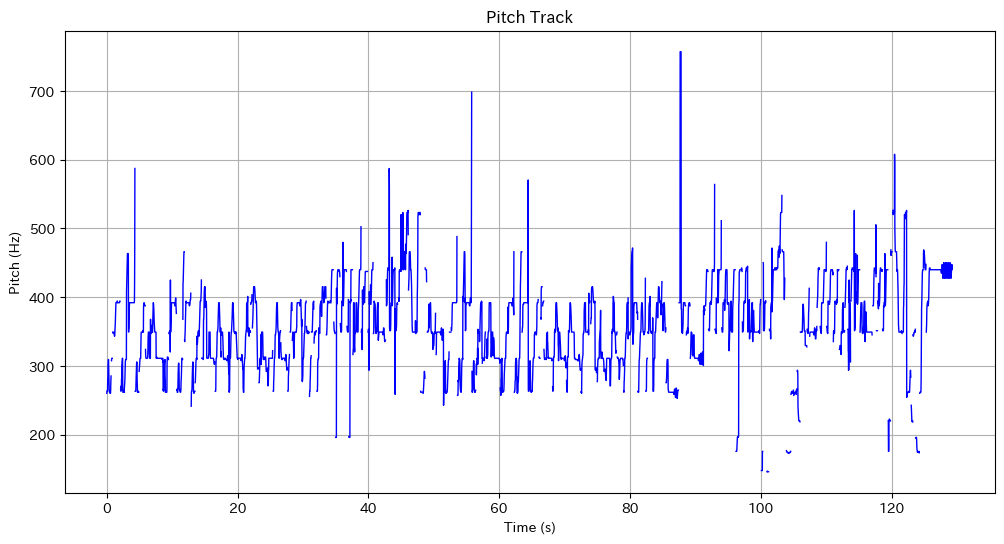

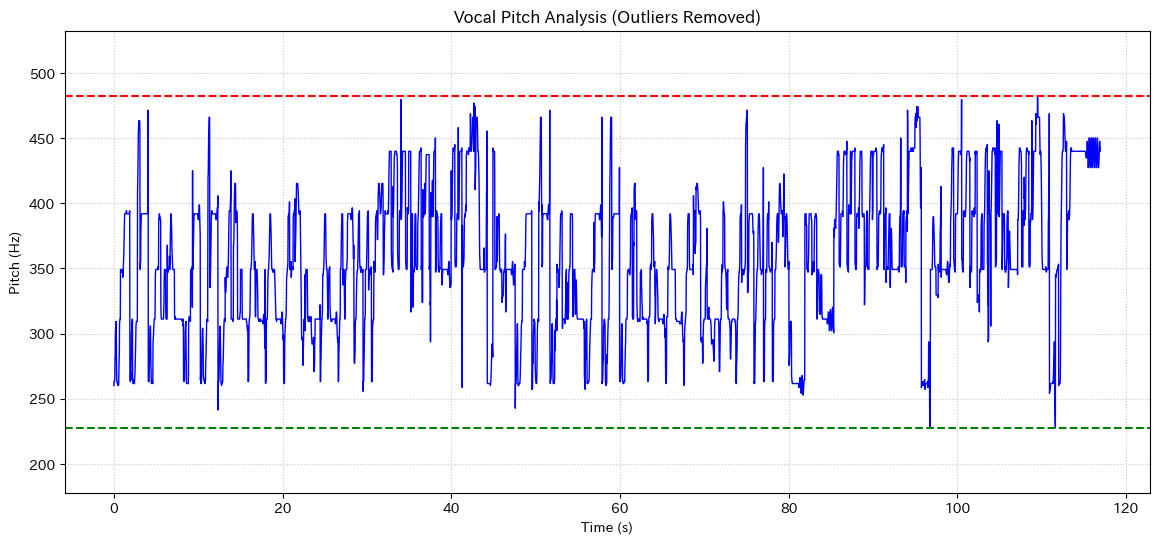

In [33]:
times = librosa.times_like(f0_combined, sr=sr)
plt.figure(figsize=(12, 6))
plt.plot(times, f0_combined, label='Pitch (Hz)', color='blue', linewidth=1)
plt.title('Pitch Track')
plt.xlabel('Time (s)')
plt.ylabel('Pitch (Hz)')
plt.grid()
plt.plot()

F0_cleaned = z_score_remove_outliers(f0_combined)

max_hz = np.max(F0_cleaned)
min_hz = np.min(F0_cleaned)
print(f"Max Frequency: {max_hz} Hz, Min Frequency: {min_hz} Hz")
max_midi = hz_to_midi(max_hz)
min_midi = hz_to_midi(min_hz)
max_note = midi_to_simplified_note_name(max_midi)
min_note = midi_to_simplified_note_name(min_midi)


print(f"Max MIDI: {max_midi}, Min MIDI: {min_midi}")
print(f"Max Note: {max_note}, Min Note: {min_note}")

F0_times = librosa.times_like(F0_cleaned, sr=sr)

plt.figure(figsize=(14, 6))
plt.plot(F0_times, F0_cleaned, label='Pitch (Hz) - Cleaned', color='blue', linewidth=1)
plt.axhline(y=max_hz, color='red', linestyle='--', label=f'MID Max Pitch: {max_note} ({max_hz:.2f} Hz)')
plt.axhline(y=min_hz, color='green', linestyle='--', label=f'MID Min Pitch: {min_note} ({min_hz:.2f} Hz)')
plt.ylim([min_hz - 50, max_hz + 50])
plt.title('Vocal Pitch Analysis (Outliers Removed)')
plt.xlabel('Time (s)')
plt.ylabel('Pitch (Hz)')
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

11
10


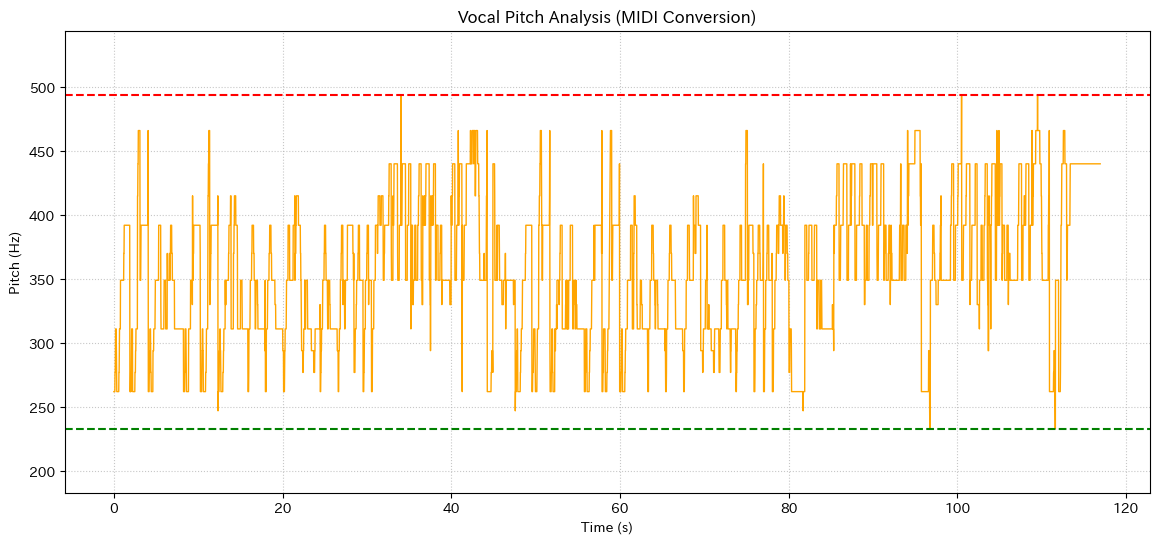

Max Frequency: 494 Hz, Min Frequency: 233 Hz
Max MIDI: 71, Min MIDI: 58
Max Note: hiB, Min Note: mid2A#


In [32]:
# 帰ってきた結果のhzをmidiナンバーに変換
f0_midi = [hz_to_midi(f) if f is not None else None for f in F0_cleaned]
# midiナンバーをhzに変換
f0_hz = [midi_to_hz(m) if m is not None else None for m in f0_midi]

max_hz = np.max(f0_hz)
min_hz = np.min(f0_hz)
max_midi = hz_to_midi(max_hz)
min_midi = hz_to_midi(min_hz)
max_note = midi_to_simplified_note_name(max_midi)
min_note = midi_to_simplified_note_name(min_midi)

# グラフの描画
plt.figure(figsize=(14, 6))
plt.plot(F0_times, f0_hz, label='Pitch (Hz) - MIDI', color='orange', linewidth=1)
plt.axhline(y=max_hz, color='red', linestyle='--', label=f'MID Max Pitch: {max_note} ({max_hz:.2f} Hz)')
plt.axhline(y=min_hz, color='green', linestyle='--', label=f'MID Min Pitch: {min_note} ({min_hz:.2f} Hz)')
plt.ylim([min_hz - 50, max_hz + 50])
plt.title('Vocal Pitch Analysis (MIDI Conversion)')
plt.xlabel('Time (s)')
plt.ylabel('Pitch (Hz)')
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

print(f"Max Frequency: {max_hz} Hz, Min Frequency: {min_hz} Hz")
print(f"Max MIDI: {max_midi}, Min MIDI: {min_midi}")
print(f"Max Note: {max_note}, Min Note: {min_note}")

max hiA min mid1A#
max mid2G min lowE
max mid2F# min lowF#